# Posterior Predictive Checks in PyMC3

PPCs are a great way to validate a model. The idea is to generate data sets from the model using parameter settings from draws from the posterior.

`PyMC3` has random number support thanks to [Mark Wibrow](https://github.com/mwibrow) as implemented in [PR784](https://github.com/pymc-devs/pymc3/pull/784).

Here we will implement a general routine to draw samples from the observed nodes of a model.

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


Lets generate a very simple model:

In [2]:
data = np.random.randn(100)

with pm.Model() as model: 
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)
    
    step = pm.NUTS()
    trace = pm.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 2.4 sec

/home/wiecki/miniconda3/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


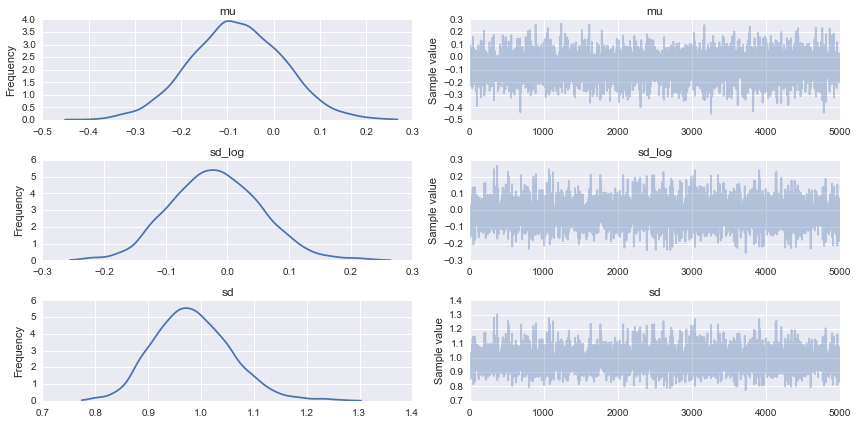

In [3]:
pm.traceplot(trace);

This function will make it into `PyMC3` eventually, for now this should work on all models:

In [4]:
def run_ppc(trace, samples=100, model=None):
    """Generate Posterior Predictive samples from a model given a trace.
    """
    if model is None:
         model = pm.modelcontext(model)
    
    ppc = defaultdict(list)
    for idx in np.random.randint(0, len(trace), samples):
        param = trace[idx]
        for obs in model.observed_RVs:
            ppc[obs.name].append(obs.distribution.random(point=param))
    
    return ppc

In [5]:
ppc = run_ppc(trace, samples=500, model=model)

`ppc` contains 500 generated data sets (containing 50 samples each), each using a different parameter setting from the posterior:

In [19]:
np.asarray(ppc['o']).shape

(500, 50)

One common way to visualize is to look if the model can reproduce the patterns observed in the real data. For example, how close are the inferred means to the actual sample mean:

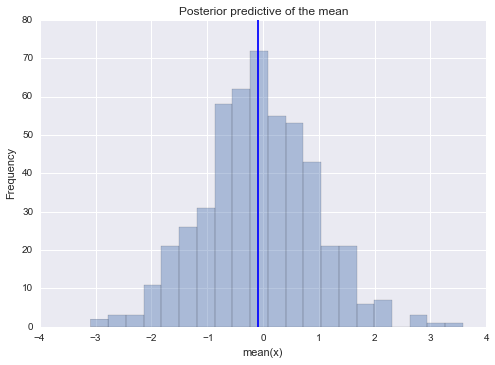

In [6]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc['n']], kde=False, ax=ax)
ax.axvline(data.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

# Prediction

The same pattern can be used for prediction. Here we're building a logistic regression model. Note that since we're dealing the full posterior, we're also getting uncertainty in our predictions for free.

In [7]:
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

In [8]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

n = 4000
n_oos = 50
coeff = 1.

predictors = np.random.normal(size=n)
# Turn predictor into a shared var so that we can change it later
predictors_shared = shared(predictors)

outcomes = np.random.binomial(1, invlogit(coeff * predictors))

In [9]:
outcomes

array([1, 1, 0, ..., 1, 0, 0])

In [10]:
predictors_oos = np.random.normal(size=50)
outcomes_oos = np.random.binomial(1, invlogit(coeff * predictors_oos))

In [12]:
def tinvlogit(x):
    import theano.tensor as t
    return t.exp(x) / (1 + t.exp(x))

with pm.Model() as model:
    coeff = pm.Normal('coeff', mu=0, sd=1)
    p = tinvlogit(coeff * predictors_shared)

    o = pm.Bernoulli('o', p, observed=outcomes)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(500, step)

 [-----------------100%-----------------] 500 of 500 complete in 2.6 sec

In [13]:
# Changing values here will also change values in the model
predictors_shared.set_value(predictors_oos)

In [14]:
# Simply running PPC will use the updated values and do prediction
ppc = run_ppc(trace, model=model, samples=500)

## Mean predicted values plus error bars to give sense of uncertainty in prediction

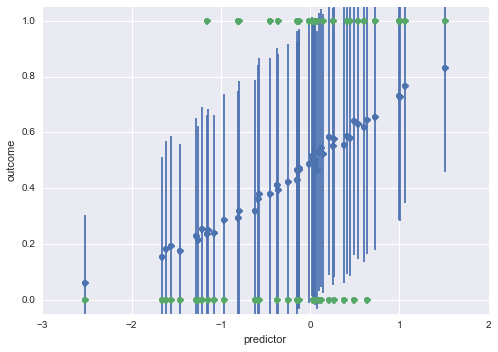

In [15]:
plt.errorbar(x=predictors_oos, y=np.asarray(ppc['o']).mean(axis=0), yerr=np.asarray(ppc['o']).std(axis=0), linestyle='', marker='o')
plt.plot(predictors_oos, outcomes_oos, 'o')
plt.ylim(-.05, 1.05)
plt.xlabel('predictor')
plt.ylabel('outcome')